This Jupyter notebook visualizes election-related social media activity as a heatmap, showing post counts from November 9, 2022, to May 6, 2025, using data from election-index.

The code below imports libraries for:

requests, requests.auth.HTTPBasicAuth: Fetch data from APIs (e.g., social media).
json: Parse election_date_count.json.
numpy: Manage grid data.
matplotlib.pyplot, matplotlib.patches: Create the heatmap and legend.
datetime, timedelta: Generate date sequences.

These enable data retrieval, processing, and visualization of post frequency trends.

In [4]:
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from requests.auth import HTTPBasicAuth
from datetime import datetime, timedelta

Set up a query to retrieve aggregated daily post counts from an Elasticsearch index (election-index) hosted locally. The code defines:

url: The Elasticsearch endpoint (https://localhost:9200/election-index/_search) for querying data.
auth: Uses HTTPBasicAuth with credentials (elastic:elastic) for secure access to the Elasticsearch instance.
query: An Elasticsearch aggregation query that:
  Sets size: 0 to exclude individual post data, focusing on aggregated results.
  Uses a date_histogram aggregation (posts_over_time) to group posts by day based on the created_at field, with a calendar_interval of one day.
This query collects the number of posts per day, which will be processed and saved as election_date_count.json for the heatmap visualization in subsequent cells.

In [2]:
url = "https://localhost:9200/election-index/_search"  # HTTPS
auth = HTTPBasicAuth("elastic", "elastic")  

# Elasticsearch
query = {
    "size": 0,  # Don't requite original posts
    "aggs": {
        "posts_over_time": {
            "date_histogram": {
                "field": "created_at",
                "calendar_interval": "day"
            }
        }
    }
}

Send the Elasticsearch query defined earlier to the specified endpoint and processes the response:

requests.post: Sends a POST request to the Elasticsearch URL with the query as JSON, using auth for authentication and verify=False to bypass SSL verification (useful for local testing with self-signed certificates).
response.raise_for_status: Raises an exception if the HTTP request fails (e.g., 4xx or 5xx status codes), ensuring robust error handling.
print(response.json()): Outputs the JSON response from Elasticsearch, which contains the aggregated daily post counts from the posts_over_time date histogram.

This step retrieves the raw data needed for the heatmap, allowing inspection of the response structure before further processing.

In [5]:
response = requests.post(url, json=query, auth=auth, verify=False)  # verify=False to skip SSL

response.raise_for_status()

print(response.json())

{'took': 2, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 3573, 'relation': 'eq'}, 'max_score': None, 'hits': []}, 'aggregations': {'posts_over_time': {'buckets': [{'key_as_string': '2022-11-09T00:00:00.000Z', 'key': 1667952000000, 'doc_count': 1}, {'key_as_string': '2022-11-10T00:00:00.000Z', 'key': 1668038400000, 'doc_count': 4}, {'key_as_string': '2022-11-11T00:00:00.000Z', 'key': 1668124800000, 'doc_count': 0}, {'key_as_string': '2022-11-12T00:00:00.000Z', 'key': 1668211200000, 'doc_count': 0}, {'key_as_string': '2022-11-13T00:00:00.000Z', 'key': 1668297600000, 'doc_count': 0}, {'key_as_string': '2022-11-14T00:00:00.000Z', 'key': 1668384000000, 'doc_count': 0}, {'key_as_string': '2022-11-15T00:00:00.000Z', 'key': 1668470400000, 'doc_count': 0}, {'key_as_string': '2022-11-16T00:00:00.000Z', 'key': 1668556800000, 'doc_count': 0}, {'key_as_string': '2022-11-17T00:00:00.000Z', 'key': 1668643200000, 'doc_count': 0}, 

/Users/eloy/.pyenv/versions/myenv/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Processe the Elasticsearch response to create a dictionary mapping dates to post counts:

buckets: Extracts the buckets list from the posts_over_time aggregation in the JSON response, where each bucket contains a date (key_as_string) and the number of posts (doc_count) for that day.
date_count_dict: Constructs a dictionary using a dictionary comprehension, where:
Keys are the first 10 characters of key_as_string (e.g., 2022-11-09 from 2022-11-09T00:00:00.000Z) to represent dates in YYYY-MM-DD format.
Values are the corresponding doc_count (number of posts on that date).
This dictionary (date_count_dict) provides the daily post counts needed for the heatmap visualization, ready to be saved or used in subsequent cells.

In [6]:
buckets = response.json()["aggregations"]["posts_over_time"]["buckets"]

date_count_dict = {
    bucket["key_as_string"][:10]: bucket["doc_count"]
    for bucket in buckets
}

Save the processed daily post counts to a JSON file for use in the heatmap visualization:

with open("election_date_count.json", "w"): Opens (or creates) the file election_date_count.json in write mode.
json.dump(date_count_dict, outfile, indent=4): Writes the date_count_dict (containing date-to-post-count mappings) to the file in JSON format with indentation for readability.

This step ensures the aggregated post counts are stored in election_date_count.json, which will be loaded later to generate the heatmap.

In [7]:
with open("election_date_count.json", "w") as outfile:
    json.dump(date_count_dict, outfile, indent=4)

print("Date: count saved into election_date_count.json.")

Date: count saved into election_date_count.json.


Load daily post counts from election_date_count.json and prepares them for the heatmap visualization. It:

Reads the JSON file into a dictionary, with a fallback to sample data if the file is missing.
Generates a complete date sequence (2022-11-09 to 2025-05-06).
Creates a count list, assigning 0 to missing dates.
Organizes the data into a grid (50 columns) using NumPy arrays for efficient processing.

In [8]:
# Load date: count dictionary
try:
    with open("election_date_count.json", "r") as f:
        date_count = json.load(f)
except FileNotFoundError:
    print("Error: election_date_count.json not found. Using sample data.")
    date_count = {"2022-11-09": 10, "2022-11-10": 50, "2022-11-11": 200}

# Generate complete date sequence
start_date = datetime.strptime("2022-11-09", "%Y-%m-%d")
end_date = datetime.strptime("2025-05-06", "%Y-%m-%d")
all_dates = [(start_date + timedelta(days=i)).strftime("%Y-%m-%d") 
             for i in range((end_date - start_date).days + 1)]

# Convert to count list, missing dates get 0
count_list = [date_count.get(date, 0) for date in all_dates]

# Set grid parameters
row_length = 50
num_rows = (len(count_list) + row_length - 1) // row_length

# Pad data
padded_counts = count_list + [None] * (num_rows * row_length - len(count_list))
padded_dates = all_dates + [None] * (num_rows * row_length - len(all_dates))

# Convert to NumPy arrays
grid_counts = np.array(padded_counts).reshape((num_rows, row_length))
grid_dates = np.array(padded_dates).reshape((num_rows, row_length))

Define the color mapping and legend for the heatmap, visualizing post counts:

The get_color function assigns colors based on count ranges, transitioning from light blue (#e0f7fa for 0) to vibrant red (#d32f2f for ≥161).
The legend_labels list pairs count ranges with their corresponding colors for the heatmap’s legend.

In [9]:
# Define color function
def get_color(value):
    if value is None:
        return "#ffffff"     
    elif value == 0:
        return "#e0f7fa"     # very light blue
    elif 1 <= value <= 5:
        return "#90caf9"     # light blue
    elif 6 <= value <= 10:
        return "#64b5f6"     # blue
    elif 11 <= value <= 20:
        return "#9575cd"     # light purple
    elif 21 <= value <= 40:
        return "#ffb74d"     # light yellow
    elif 41 <= value <= 80:
        return "#ff8a65"     # orange pink
    elif 81 <= value <= 160:
        return "#f06292"     # pink
    else:  # >= 161
        return "#d32f2f"     # red

legend_labels = [
    ("0", "#e0f7fa"),
    ("1–5", "#90caf9"),
    ("6–10", "#64b5f6"),
    ("11–20", "#9575cd"),
    ("21–40", "#ffb74d"),
    ("41–80", "#ff8a65"),
    ("81–160", "#f06292"),
    ("161+", "#d32f2f"),
]

Creates and displays the heatmap to visualize daily post counts:

Uses Matplotlib to draw a grid of rectangles, colored according to the post counts.
Sets the grid size (50 columns, dynamic rows) and ensures equal aspect ratio.

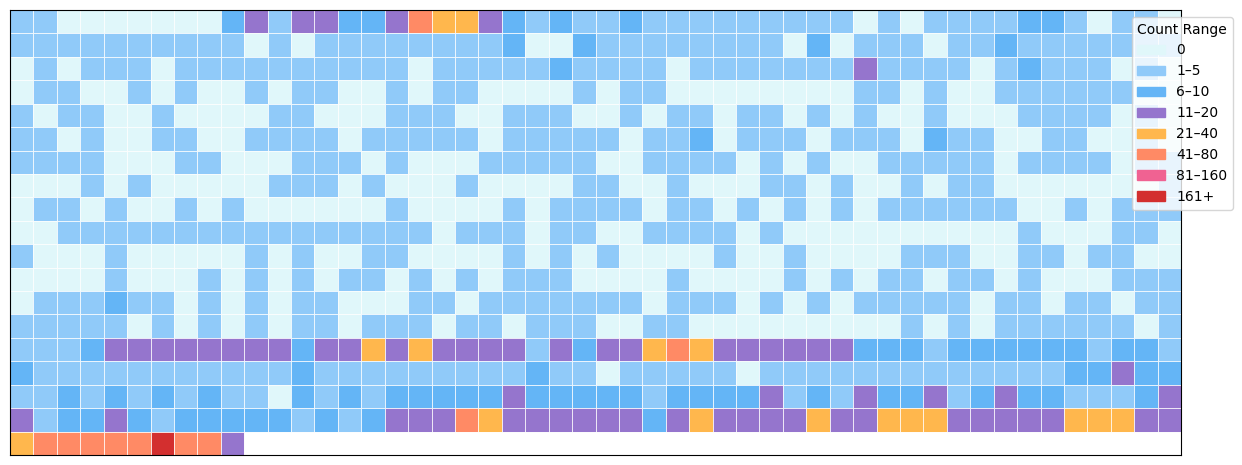

In [10]:
fig, ax = plt.subplots(figsize=(row_length * 0.25, num_rows * 0.25))

# Draw grid heatmap
for row in range(num_rows):
    for col in range(row_length):
        value = grid_counts[row, col]
        color = get_color(value)
        rect = plt.Rectangle((col, num_rows - 1 - row), 1, 1, facecolor=color, edgecolor="white", lw=0.5)
        ax.add_patch(rect)

# Set axis limits
ax.set_xlim(0, row_length)
ax.set_ylim(0, num_rows)

# Hide ticks
ax.set_xticks([])
ax.set_yticks([])

# Add legend
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in legend_labels]
ax.legend(handles=legend_handles, loc="upper right", bbox_to_anchor=(1.05, 1), title="Count Range")

# Set equal aspect ratio
ax.set_aspect("equal")

plt.tight_layout()
plt.show()